# Leaf Classification CNN

## Libraries

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')
#%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import cv2
import sys, os, shutil, glob, random, csv, time
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from sklearn.model_selection import train_test_split

## Data IO / Image Preprocessing

In [13]:
#IO functions

def load_image(file_path):
    return cv2.imread(file_path)

def create_directory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        pass

def extract_names(label_file):
    names = list()
    with open('label_legend.csv', newline='') as f:
        reader = csv.reader(f)
        legend = dict(reader)
    for img in label_file:
        names.append(legend[str(img)])
    return names

def process_data(source_path, dest_path, desired_size, transform=False, edges=False):
    create_directory(dest_path)
    names = []
    legend = dict()
    j=0
    species_folders = os.listdir(source_path)
    for i, folder in enumerate(species_folders):
        if folder[0] == '.':
            continue
        id = str(i).rjust(2, '0')
        legend[folder] = id
        folder_path = os.listdir(os.path.join(source_path, folder))
        num_folders = len(folder_path)
        clear_output(wait=True)
        print("Folder:", i, "/100", flush=True)
        for jpgfile in folder_path:
            #resize
            img = load_image(os.path.join(source_path, folder, jpgfile))
            old_size = img.shape[:2]
            ratio = float(desired_size)/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])
            img = cv2.resize(img, (new_size[1], new_size[0]))
            delta_w = desired_size - new_size[1]
            delta_h = desired_size - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)

            color = [0, 0, 0]
            new_im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
                value=color)
    
            #rename
            new_name = id + str(j)
            j += 1
            fname = os.path.join(dest_path, new_name)
            if edges:
                new_im = cv2.Canny(new_im, 100, 200)
            if transform:
                # 2x mirror
                img_flip_vert = np.flip(new_im, axis=0)
                filename = os.path.join(fname + '_vert.jpg')
                cv2.imwrite(filename, img_flip_vert)

                img_flip_horiz = np.flip(new_im, axis=1)
                filename = os.path.join(fname + '_horiz.jpg')
                cv2.imwrite(filename, img_flip_horiz)

                # rotate 3 times and save
                for i in range(1, 4):
                    img_flip_vert = cv2.rotate(img_flip_vert, cv2.ROTATE_90_CLOCKWISE)
                    filename = os.path.join(fname + '_' + str(i*90) + '_vert.jpg')
                    cv2.imwrite(filename, img_flip_vert)

                    img_flip_horiz = cv2.rotate(img_flip_horiz, cv2.ROTATE_90_CLOCKWISE)
                    filename = os.path.join(fname + '_' + str(i*90) + '_horiz.jpg')
                    cv2.imwrite(filename, img_flip_horiz)
            cv2.imwrite(os.path.join(fname+'.jpg'), new_im)
    csv_name = 'label_legend.csv'
    with open(csv_name, 'w') as csvfile:
        for key in legend.keys():
            csvfile.write("%d,%s\n"%(int(legend[key]), key))
            
def blackandwhite(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return img / 255.0
            

In [17]:
#copy dataset into dest_name folder and create a 'label legend'

def masterSet(dest_name='sixty-for', desired_size=64, trans=False, edge=False, test_perc=.2, seed=101):
    #root_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'datasets')
    root_path = os.path.join(os.getcwd(), 'datasets')
    dest_path = os.path.join(root_path, dest_name)
    process_data(os.path.join(root_path, '100 leaves plant species', 'data'), dest_path, desired_size, transform=trans, edges=edge)
    data_path = dest_path
    image_files = os.listdir(dest_path)
    data = [load_image(os.path.join(data_path, file)) for file in image_files]
    data = [blackandwhite(img) for img in data]
    labels = [int(file[:2]) for file in image_files]
    #Split processed dataset into training and validation
    train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=test_perc, random_state=random_seed)
    train_images = np.expand_dims(train_images, axis=-1)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    return train_images, test_images, train_labels, test_labels

In [19]:
train_images, test_images, train_labels, test_labels = masterSet()

Folder: 99 /100


In [20]:
print(type(train_images[0]), type(train_labels[0]))
print(train_labels[:15])
print(train_images.shape, train_labels.shape)
print(train_images[0].shape)

<class 'numpy.ndarray'> <class 'numpy.int32'>
[77 53 56 84 54 33 11 50 92 63 86 27 53 69 19]
(1200, 64, 64, 1) (1200,)
(64, 64, 1)


## CONVOLUTIONAL NET

In [29]:
epoch = 10
batch = 50

layers = [
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    #tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    #tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=100, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(layers)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])
history = model.fit(train_images, train_labels, epochs=epoch, batch_size=batch)
print(history.history)
model.save_weights("model.tf")

Train on 1200 samples
Epoch 1/10
1200/1200 [==============================] - 2s 1ms/sample - loss: 4.3983 - sparse_categorical_accuracy: 0.0508
Epoch 2/10
1200/1200 [==============================] - 1s 986us/sample - loss: 3.1576 - sparse_categorical_accuracy: 0.2158
Epoch 3/10
1200/1200 [==============================] - 1s 973us/sample - loss: 2.2354 - sparse_categorical_accuracy: 0.3692
Epoch 4/10
1200/1200 [==============================] - 1s 995us/sample - loss: 1.7545 - sparse_categorical_accuracy: 0.4817
Epoch 5/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 1.4762 - sparse_categorical_accuracy: 0.5683
Epoch 6/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 1.2839 - sparse_categorical_accuracy: 0.6183
Epoch 7/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 1.0609 - sparse_categorical_accuracy: 0.6883
Epoch 8/10
1200/1200 [==============================] - 1s 1ms/sample - loss: 0.9566 - sparse_categorical_accur

In [71]:
hist_name = "CNNhist_" + str(desired_size) + ('_trans_' if trans == True else '_') + ('edge_' if edge == True else '') + str(epoch) + '_' + str(batch)
create_directory('hist_stats')
csv_file = os.path.join('hist_stats', hist_name + '.csv')
hist = history.history
try:
    with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(hist.keys())
        writer.writerows(zip(*hist.values()))       
except IOError:
    print("I/O error")

I/O error


Test Accuracy =  0.6125


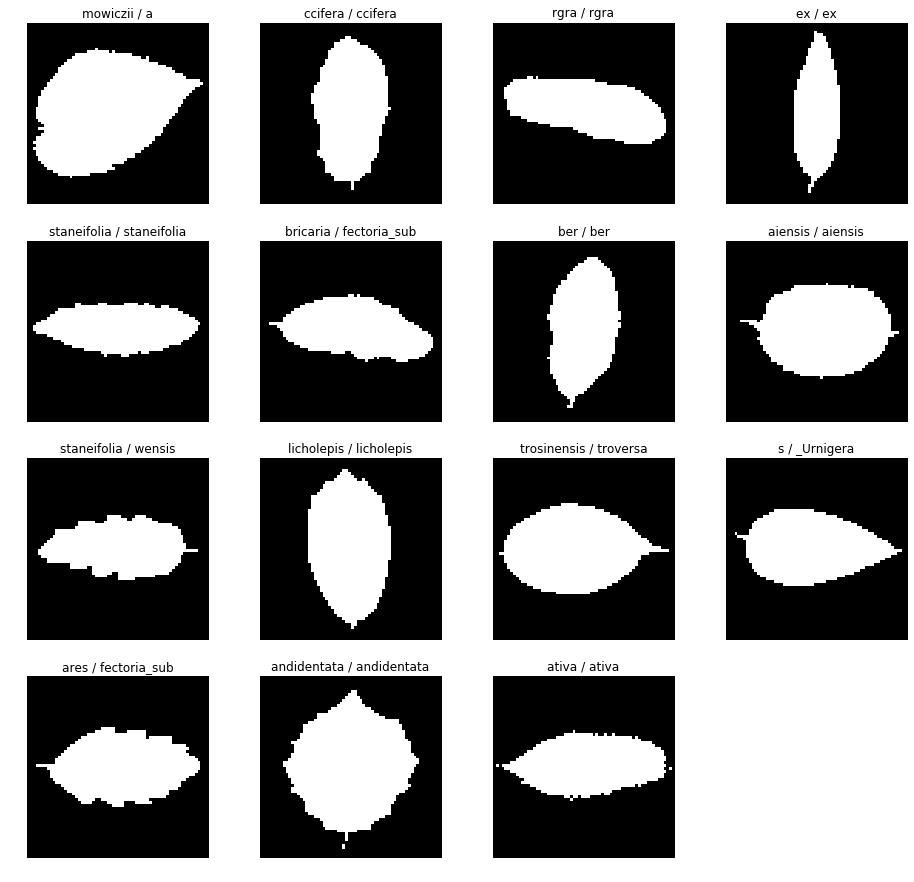

In [8]:
eval_model = tf.keras.Sequential(layers)
eval_model.load_weights("model.tf")
eval_predictions = eval_model.predict(np.expand_dims(test_images, axis=-1))
cols = 4
rows = np.ceil(len(test_images)/cols)
fig = plt.gcf()
fig.set_size_inches(cols * 4, rows * 4)
predicted_labels = np.argmax(eval_predictions, axis=1)
predicted_names = extract_names(predicted_labels)
predicted_correct = [1 if predicted_labels[i] ==  test_labels[i] else 0 for i in range(len(test_labels))  ]
accuracy = np.sum(predicted_correct) / len(test_labels)
print("Test Accuracy = ", accuracy)
for i in range(15):
    plt.subplot(rows, cols, i+1)
    plt.imshow(test_images[i], cmap="gray")
    title = predicted_names[i][10:] + " / " + test_label_name[i][10:]
    plt.title(title)
    plt.axis('off')

## KNN

In [9]:
# Distance between instances x1 and x2
def dist(x1, x2):
    distance = x1 - x2
    return np.linalg.norm(distance)

# Predict label for instance x, using k nearest neighbors in training data
def classify_knn(train_x, train_y, k, x):
    # keep a list of all the distances with the values
    distances = []
    for i, data in enumerate(train_x):
        # caluclate distance between x and data
        distance = dist(x, data)
        # add distance and label to list
        distances.append((distance, train_y[i]))

    # sort list of distances
    distances.sort()

    # tally up the results of the first k items in the sorted list
    results = {}
    best = (None, 0)
    for i in range(k):
        distance, label = distances[i]
        # increment label by 1 if the label exists, or set to 1 if it doesn't
        results[label] = results.get(label, 0) + 1
        # keep track of the label with the most "votes"
        if (results[label] > best[1]):
            best = (label, results[label])

    return best[0]

# Run classifier and compute accuracy
def runTest(test_x, test_y, train_x, train_y, k):
    num_iters = test_x.shape[0]
    correct = 0
    i = 1
    for (x,y) in zip(test_x, test_y):
        clear_output(wait=True)
        print('progress: {:.2f}% complete'.format(100* i/num_iters))
        i += 1
        if classify_knn(train_x, train_y, k, x) == y:
            correct += 1
    acc = float(correct)/len(test_x)
    return acc

In [5]:
results = [((10, 1, 'transformations', 'only edge'), 0.6738888888888889), ((10, 1, 'transformations', 'whole image'), 0.6947222222222222), ((10, 1, 'no transformations', 'only edge'), 0.3675), ((10, 1, 'no transformations', 'whole image'), 0.4025), ((10, 3, 'transformations', 'only edge'), 0.43833333333333335), ((10, 3, 'transformations', 'whole image'), 0.4661111111111111), ((10, 3, 'no transformations', 'only edge'), 0.39), ((10, 3, 'no transformations', 'whole image'), 0.4075), ((10, 5, 'transformations', 'only edge'), 0.37083333333333335), ((10, 5, 'transformations', 'whole image'), 0.4022222222222222), ((10, 5, 'no transformations', 'only edge'), 0.3775), ((10, 5, 'no transformations', 'whole image'), 0.3925), ((10, 10, 'transformations', 'only edge'), 0.36194444444444446), ((10, 10, 'transformations', 'whole image'), 0.39861111111111114), ((10, 10, 'no transformations', 'only edge'), 0.3375), ((10, 10, 'no transformations', 'whole image'), 0.385), ((16, 1, 'transformations', 'only edge'), 0.7794444444444445), ((16, 1, 'transformations', 'whole image'), 0.7991666666666667), ((16, 1, 'no transformations', 'only edge'), 0.3525), ((16, 1, 'no transformations', 'whole image'), 0.4325), ((16, 3, 'transformations', 'only edge'), 0.5027777777777778), ((16, 3, 'transformations', 'whole image'), 0.5547222222222222), ((16, 3, 'no transformations', 'only edge'), 0.3575), ((16, 3, 'no transformations', 'whole image'), 0.455), ((16, 5, 'transformations', 'only edge'), 0.41555555555555557), ((16, 5, 'transformations', 'whole image'), 0.48083333333333333), ((16, 5, 'no transformations', 'only edge'), 0.365), ((16, 5, 'no transformations', 'whole image'), 0.425), ((16, 10, 'transformations', 'only edge'), 0.41), ((16, 10, 'transformations', 'whole image'), 0.45861111111111114), ((16, 10, 'no transformations', 'only edge'), 0.335), ((16, 10, 'no transformations', 'whole image'), 0.4125), ((32, 1, 'transformations', 'only edge'), 0.7877777777777778), ((32, 1, 'transformations', 'whole image'), 0.8155555555555556), ((32, 1, 'no transformations', 'only edge'), 0.4375), ((32, 1, 'no transformations', 'whole image'), 0.515), ((32, 3, 'transformations', 'only edge'), 0.5336111111111111), ((32, 3, 'transformations', 'whole image'), 0.6011111111111112), ((32, 3, 'no transformations', 'only edge'), 0.4225), ((32, 3, 'no transformations', 'whole image'), 0.5225), ((32, 5, 'transformations', 'only edge'), 0.4375), ((32, 5, 'transformations', 'whole image'), 0.5402777777777777), ((32, 5, 'no transformations', 'only edge'), 0.44), ((32, 5, 'no transformations', 'whole image'), 0.5275), ((32, 10, 'transformations', 'only edge'), 0.42583333333333334), ((32, 10, 'transformations', 'whole image'), 0.5222222222222223), ((32, 10, 'no transformations', 'only edge'), 0.39), ((32, 10, 'no transformations', 'whole image'), 0.485), ((64, 1, 'transformations', 'only edge'), 0.7766666666666666), ((64, 1, 'transformations', 'whole image'), 0.8177777777777778), ((64, 1, 'no transformations', 'only edge'), 0.4075), ((64, 1, 'no transformations', 'whole image'), 0.5375), ((64, 3, 'transformations', 'only edge'), 0.5116666666666667), ((64, 3, 'transformations', 'whole image'), 0.6180555555555556), ((64, 3, 'no transformations', 'only edge'), 0.395), ((64, 3, 'no transformations', 'whole image'), 0.53), ((64, 5, 'transformations', 'only edge'), 0.3794444444444444), ((64, 5, 'transformations', 'whole image'), 0.5413888888888889), ((64, 5, 'no transformations', 'only edge'), 0.375), ((64, 5, 'no transformations', 'whole image'), 0.5025), ((64, 10, 'transformations', 'only edge'), 0.36972222222222223), ((64, 10, 'transformations', 'whole image'), 0.5363888888888889), ((64, 10, 'no transformations', 'only edge'), 0.3425), ((64, 10, 'no transformations', 'whole image'), 0.51)]
results

[((10, 1, 'transformations', 'only edge'), 0.6738888888888889),
 ((10, 1, 'transformations', 'whole image'), 0.6947222222222222),
 ((10, 1, 'no transformations', 'only edge'), 0.3675),
 ((10, 1, 'no transformations', 'whole image'), 0.4025),
 ((10, 3, 'transformations', 'only edge'), 0.43833333333333335),
 ((10, 3, 'transformations', 'whole image'), 0.4661111111111111),
 ((10, 3, 'no transformations', 'only edge'), 0.39),
 ((10, 3, 'no transformations', 'whole image'), 0.4075),
 ((10, 5, 'transformations', 'only edge'), 0.37083333333333335),
 ((10, 5, 'transformations', 'whole image'), 0.4022222222222222),
 ((10, 5, 'no transformations', 'only edge'), 0.3775),
 ((10, 5, 'no transformations', 'whole image'), 0.3925),
 ((10, 10, 'transformations', 'only edge'), 0.36194444444444446),
 ((10, 10, 'transformations', 'whole image'), 0.39861111111111114),
 ((10, 10, 'no transformations', 'only edge'), 0.3375),
 ((10, 10, 'no transformations', 'whole image'), 0.385),
 ((16, 1, 'transformations'

In [64]:
tt = 'transformations'
tf = 'no transformations'
et = 'only edge'
ef = 'whole image'
s10_k_tf_ef = []
s10_k_tf_et = []
s10_k_tt_ef = []
s10_k_tt_et = []
s16_k_tf_ef = []
s16_k_tf_et = []
s16_k_tt_ef = []
s16_k_tt_et = []
s32_k_tf_ef = []
s32_k_tf_et = []
s32_k_tt_ef = []
s32_k_tt_et = []
s64_k_tf_ef = []
s64_k_tf_et = []
s64_k_tt_ef = []
s64_k_tt_et = []
for params, acc in results:
    size, k, t, e = params
    if (size == 10):
        if (t == tt):
            if (e == et):
                s10_k_tt_et.append((params, acc))
            else:
                s10_k_tt_ef.append((params, acc))
        else:
            if (e == et):
                s10_k_tf_et.append((params, acc))
            else:
                s10_k_tf_ef.append((params, acc))
    if (size == 16):
        if (t == tt):
            if (e == et):
                s16_k_tt_et.append((params, acc))
            else:
                s16_k_tt_ef.append((params, acc))
        else:
            if (e == et):
                s16_k_tf_et.append((params, acc))
            else:
                s16_k_tf_ef.append((params, acc))
    if (size == 32):
        if (t == tt):
            if (e == et):
                s32_k_tt_et.append((params, acc))
            else:
                s32_k_tt_ef.append((params, acc))
        else:
            if (e == et):
                s32_k_tf_et.append((params, acc))
            else:
                s32_k_tf_ef.append((params, acc))
    if (size == 64):
        if (t == tt):
            if (e == et):
                s64_k_tt_et.append((params, acc))
            else:
                s64_k_tt_ef.append((params, acc))
        else:
            if (e == et):
                s64_k_tf_et.append((params, acc))
            else:
                s64_k_tf_ef.append((params, acc))

groups = [s10_k_tf_ef, s10_k_tf_et, s10_k_tt_ef, s10_k_tt_et, s16_k_tf_ef, s16_k_tf_et, s16_k_tt_ef, s16_k_tt_et, s32_k_tf_ef, s32_k_tf_et, s32_k_tt_ef, s32_k_tt_et, s64_k_tf_ef, s64_k_tf_et, s64_k_tt_ef, s64_k_tt_et]                
styles = ['rs--', 'rs-', 'ro--', 'ro-', 'ys--', 'ys-', 'yo--', 'yo-', 'gs--', 'gs-', 'go--', 'go-', 'bs--', 'bs-', 'bo--', 'bo-']


### size = color
10 = r  
16 = y  
32 = g  
64 = b  

### t = shape
tf = s  
tt = o

### e = line
ef = --  
et = -

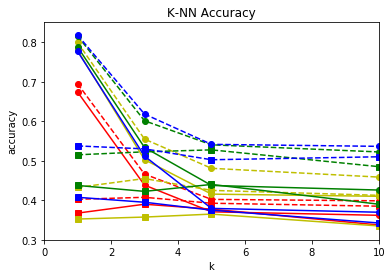

In [67]:
plt.axis([0, 10, 0.3, .85])
plt.title('K-NN Accuracy')
plt.xlabel("k")
plt.ylabel("accuracy")
for l, s in zip(groups, styles):
    xs = [x[0][1] for x in l]
    ys = [y[1] for y in l]
    plt.plot(xs, ys, s)
